# Import libraries

In [1]:
!pip install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395106 sha256=f795c11266a8e8343c2cfcc594b8ab183d5a13f203635850ff79a579e0f3a53e
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclustering


In [79]:
import matplotlib.pyplot as plt
import os.path
from pyclustering.cluster.agglomerative import agglomerative, type_link
from pyclustering.cluster.birch import birch
from pyclustering.cluster.dbscan import dbscan
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.optics import optics
from pyclustering.cluster.rock import rock
from pyclustering.cluster.xmeans import xmeans
import sklearn.datasets
import numpy as np
import pandas as pd
import time
import seaborn as sns
%matplotlib inline
sns.set_palette('Paired', 8)
sns.set_color_codes()

# Defining benchmarking function (based on https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html)

In [58]:
def benchmark_pycluster(dataset_sizes, cluster_function, function_args, function_kwds, plusplus=False, dataset_dimension=10, dataset_n_clusters=10, max_time=45, sample_size=2):
    # Get names of the module and algorithm
    module_name="pycluster"
    algorithm_name=str(cluster_function).partition('(')[0].rsplit('.',1)[1].rsplit("'",1)[0]

    # Initialize the result with NaNs so that any unfilled entries
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = np.nan * np.ones((len(dataset_sizes), sample_size))
    mean = np.nan * np.ones(len(dataset_sizes))
    for index, size in enumerate(dataset_sizes):
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, labels = sklearn.datasets.make_blobs(n_samples=size,
                                                       n_features=dataset_dimension,
                                                       centers=dataset_n_clusters)
            # kmeans requires initilisation before
            if plusplus:
              if 'kmedoids' in algorithm_name:
                centers=kmeans_plusplus_initializer(data, dataset_n_clusters).initialize(return_index=True)
              else:
                centers=kmeans_plusplus_initializer(data, dataset_n_clusters).initialize()
              print("Fitting "+algorithm_name+" for "+str(size)+" data points "+str(s))
              # Start the clustering with a timer
              start_time = time.time()
              instance=cluster_function(data, centers, *function_args, **function_kwds)
              instance.process()
              time_taken = time.time() - start_time
            else:
              print("Fitting "+algorithm_name+" for "+str(size)+" data points "+str(s))
              # Start the clustering with a timer
              start_time = time.time()
              instance=cluster_function(data, *function_args, **function_kwds)
              instance.process()
              time_taken = time.time() - start_time
            # If we are taking more than max_time then abort -- we don't
            # want to spend excessive time on slow algorithms
            if time_taken > max_time:
                result[index, s] = time_taken
                mean[index] = np.mean(result[index, ])
                return pd.DataFrame(np.vstack([dataset_sizes,
                                               mean.flatten()]).T, columns=['sample_size',algorithm_name+"_"+module_name])
            else:
                result[index, s] = time_taken
        mean[index] = np.mean(result[index, ])

    # Return the result as a dataframe for easier handling with seaborn afterwards
    return pd.DataFrame(np.vstack([dataset_sizes,
                                   mean.flatten()]).T, columns=['sample_size',algorithm_name+"_"+module_name])


# Small datasize test

First test on the smallest datasize

In [69]:
# Define different dataset sizes
small_dataset_sizes=np.hstack([np.arange(1, 6) * 500, np.arange(3,7) * 1000, np.arange(4,17) * 2000])

# Fit algorithms

df_agglomerative = benchmark_pycluster(small_dataset_sizes, agglomerative, (), {"number_clusters":10, "link":type_link.SINGLE_LINK}, sample_size=5)

# BIRCH returns error that on the first sight is caused by the package
#df_birch = benchmark_pycluster(small_dataset_sizes, birch, (), {"number_clusters":10}, sample_size=5)

# Use default eps and neighbours as in sklearn
df_dbscan = benchmark_pycluster(small_dataset_sizes, dbscan, (0.5, 5), {}, sample_size=5)

df_kmeans = benchmark_pycluster(small_dataset_sizes, kmeans, (10,), {}, sample_size=5, plusplus=True)

df_kmedians = benchmark_pycluster(small_dataset_sizes, kmedians, (), {}, sample_size=5, plusplus=True)

df_kmedoids = benchmark_pycluster(small_dataset_sizes, kmedoids, (), {}, sample_size=5, plusplus=True)

# Default number of neighbours (5 as in sklearn), in sklearn there is no need for eps parameter, just max_eps which is inf in sklearn
df_optics = benchmark_pycluster(small_dataset_sizes, optics, (0.5, 5), {}, sample_size=5)

df_rock = benchmark_pycluster(small_dataset_sizes, rock, (0.5, 10), {}, sample_size=5)

df_xmeans = benchmark_pycluster(small_dataset_sizes, xmeans, (10,), {}, sample_size=5, plusplus=True)

Fitting agglomerative for 500 data points 0
Fitting agglomerative for 500 data points 1
Fitting agglomerative for 500 data points 2
Fitting agglomerative for 500 data points 3
Fitting agglomerative for 500 data points 4
Fitting agglomerative for 1000 data points 0
Fitting agglomerative for 1000 data points 1
Fitting agglomerative for 1000 data points 2
Fitting agglomerative for 1000 data points 3
Fitting agglomerative for 1000 data points 4
Fitting agglomerative for 1500 data points 0
Fitting agglomerative for 1500 data points 1
Fitting agglomerative for 1500 data points 2
Fitting agglomerative for 1500 data points 3
Fitting agglomerative for 1500 data points 4
Fitting agglomerative for 2000 data points 0
Fitting dbscan for 500 data points 0
Fitting dbscan for 500 data points 1
Fitting dbscan for 500 data points 2
Fitting dbscan for 500 data points 3
Fitting dbscan for 500 data points 4
Fitting dbscan for 1000 data points 0
Fitting dbscan for 1000 data points 1
Fitting dbscan for 1000 

Save results to .csv file

In [71]:
data_names=[df_dbscan, df_kmeans, df_kmedians, df_kmedoids, df_optics, df_rock, df_xmeans]
df=df_agglomerative
for algo in data_names:
  df=pd.merge(df, algo, on='sample_size', how='outer')
df.to_csv("all_pycluster_times.csv")

Plot results

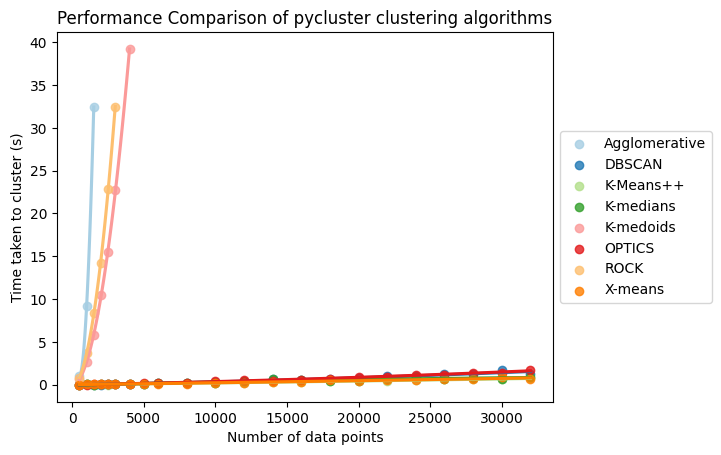

In [72]:
sns.regplot(x='sample_size', y=df.columns[1], data=df, order=2, label='Agglomerative', ci=None)
sns.regplot(x='sample_size', y=df.columns[2], data=df, order=2, label='DBSCAN', ci=None)
sns.regplot(x='sample_size', y=df.columns[3], data=df, order=2, label='K-Means++', ci=None)
sns.regplot(x='sample_size', y=df.columns[4], data=df, order=2, label='K-medians', ci=None)
sns.regplot(x='sample_size', y=df.columns[5], data=df, order=2, label='K-medoids', ci=None)
sns.regplot(x='sample_size', y=df.columns[6], data=df, order=2, label='OPTICS', ci=None)
sns.regplot(x='sample_size', y=df.columns[7], data=df, order=2, label='ROCK', ci=None)
sns.regplot(x='sample_size', y=df.columns[8], data=df, order=2, label='X-means', ci=None)

#plt.gca().axis([0, 30000, -2, 45])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of pycluster clustering algorithms')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Medium datasize test

Remove from consderation slow algorithms and move on to larger sample sizes

In [75]:
# Define larger dataset sizes
large_dataset_sizes=np.arange(1,11) * 20000

# Fit algorithms

# Use default eps and neighbours as in sklearn
df_dbscan = benchmark_pycluster(large_dataset_sizes, dbscan, (0.5, 5), {}, sample_size=5)

df_kmeans = benchmark_pycluster(large_dataset_sizes, kmeans, (10,), {}, sample_size=5, plusplus=True)

df_kmedians = benchmark_pycluster(large_dataset_sizes, kmedians, (), {}, sample_size=5, plusplus=True)

# Default number of neighbours (5 as in sklearn), in sklearn there is no need for eps parameter, just max_eps which is inf in sklearn
df_optics = benchmark_pycluster(large_dataset_sizes, optics, (0.5, 5), {}, sample_size=5)

df_xmeans = benchmark_pycluster(large_dataset_sizes, xmeans, (10,), {}, sample_size=5, plusplus=True)

Fitting dbscan for 20000 data points 0
Fitting dbscan for 20000 data points 1
Fitting dbscan for 20000 data points 2
Fitting dbscan for 20000 data points 3
Fitting dbscan for 20000 data points 4
Fitting dbscan for 40000 data points 0
Fitting dbscan for 40000 data points 1
Fitting dbscan for 40000 data points 2
Fitting dbscan for 40000 data points 3
Fitting dbscan for 40000 data points 4
Fitting dbscan for 60000 data points 0
Fitting dbscan for 60000 data points 1
Fitting dbscan for 60000 data points 2
Fitting dbscan for 60000 data points 3
Fitting dbscan for 60000 data points 4
Fitting dbscan for 80000 data points 0
Fitting dbscan for 80000 data points 1
Fitting dbscan for 80000 data points 2
Fitting dbscan for 80000 data points 3
Fitting dbscan for 80000 data points 4
Fitting dbscan for 100000 data points 0
Fitting dbscan for 100000 data points 1
Fitting dbscan for 100000 data points 2
Fitting dbscan for 100000 data points 3
Fitting dbscan for 100000 data points 4
Fitting dbscan for 1

Save results to .csv file

In [76]:
data_names=[df_kmeans, df_kmedians, df_optics, df_xmeans]
df=df_dbscan
for algo in data_names:
  df=pd.merge(df, algo, on='sample_size', how='outer')
df.to_csv("large_data_pycluster_times.csv")

Plot results

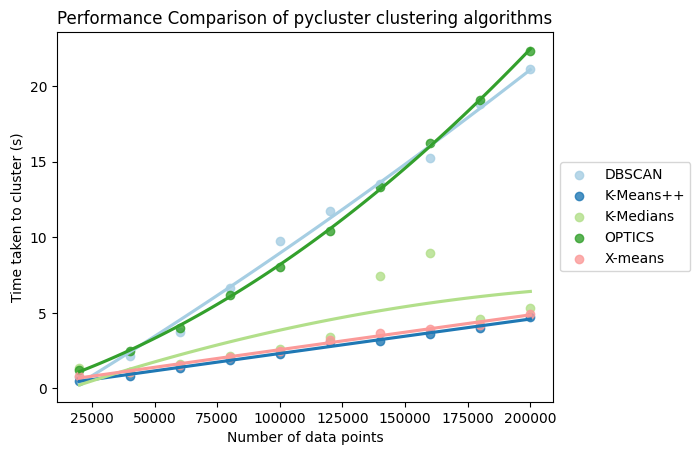

In [77]:
sns.regplot(x='sample_size', y=df.columns[1], data=df, order=2, label='DBSCAN', ci=None)
sns.regplot(x='sample_size', y=df.columns[2], data=df, order=2, label='K-Means++', ci=None)
sns.regplot(x='sample_size', y=df.columns[3], data=df, order=2, label='K-Medians', ci=None)
sns.regplot(x='sample_size', y=df.columns[4], data=df, order=2, label='OPTICS', ci=None)
sns.regplot(x='sample_size', y=df.columns[5], data=df, order=2, label='X-means', ci=None)

#plt.gca().axis([0, 30000, -2, 45])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of pycluster clustering algorithms')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Large dataset test

Again, remove slowest performing algorithms and increase datasize

In [81]:
# Define larger dataset sizes
huge_dataset_sizes=np.arange(1,11) * 100000

# Fit algorithms

df_kmeans = benchmark_pycluster(huge_dataset_sizes, kmeans, (10,), {}, sample_size=5, plusplus=True)

df_kmedians = benchmark_pycluster(huge_dataset_sizes, kmedians, (), {}, sample_size=5, plusplus=True)

df_xmeans = benchmark_pycluster(huge_dataset_sizes, xmeans, (10,), {}, sample_size=5, plusplus=True)

Fitting kmeans for 100000 data points 0
Fitting kmeans for 100000 data points 1
Fitting kmeans for 100000 data points 2
Fitting kmeans for 100000 data points 3
Fitting kmeans for 100000 data points 4
Fitting kmeans for 200000 data points 0
Fitting kmeans for 200000 data points 1
Fitting kmeans for 200000 data points 2
Fitting kmeans for 200000 data points 3
Fitting kmeans for 200000 data points 4
Fitting kmeans for 300000 data points 0
Fitting kmeans for 300000 data points 1
Fitting kmeans for 300000 data points 2
Fitting kmeans for 300000 data points 3
Fitting kmeans for 300000 data points 4
Fitting kmeans for 400000 data points 0
Fitting kmeans for 400000 data points 1
Fitting kmeans for 400000 data points 2
Fitting kmeans for 400000 data points 3
Fitting kmeans for 400000 data points 4
Fitting kmeans for 500000 data points 0
Fitting kmeans for 500000 data points 1
Fitting kmeans for 500000 data points 2
Fitting kmeans for 500000 data points 3
Fitting kmeans for 500000 data points 4


Save results to .csv file

In [82]:
data_names=[df_kmedians, df_xmeans]
df=df_kmeans
for algo in data_names:
  df=pd.merge(df, algo, on='sample_size', how='outer')
df.to_csv("huge_data_pycluster_times.csv")

Plot results

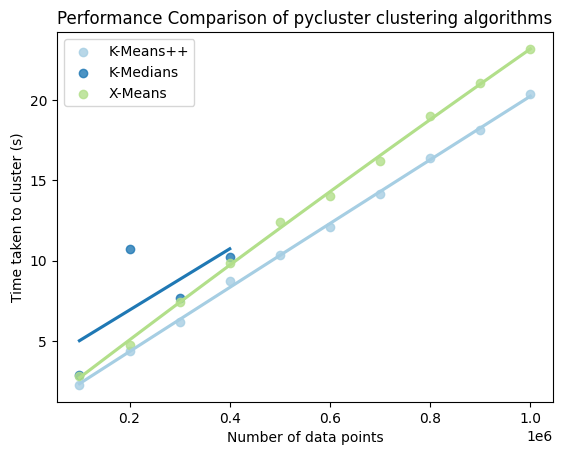

In [85]:
sns.regplot(x='sample_size', y=df.columns[1], data=df, order=2, label='K-Means++', ci=None)
sns.regplot(x='sample_size', y=df.columns[2], data=df, order=1, label='K-Medians', ci=None)
sns.regplot(x='sample_size', y=df.columns[3], data=df, order=2, label='X-Means', ci=None)

#plt.gca().axis([0, 30000, -2, 45])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of pycluster clustering algorithms')
plt.legend()